In [1]:
pip install google-play-scraper pandas numpy nltk sastrawi langdetect wordcloud matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Memanggil seluruh library yang diperlukan
import pandas as pd
import numpy as np
import re
import nltk
from google_play_scraper import Sort, reviews
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from langdetect import detect, LangDetectException
from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Mengunduh resource NLTK yang diperlukan (cukup sekali jalan)
try:
    nltk.data.find('tokenizers/punkt')
except nltk.downloader.DownloadError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except nltk.downloader.DownloadError:
    nltk.download('stopwords')

## Proses Scraping

In [3]:
# mulai scraping
result, continuation_token = reviews(
    'com.strava', #masukkan link setelah kata 'id'
    lang='id', # defaults to 'en'
    country='id', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    count=2000, # defaults to 100
    filter_score_with=None # defaults to None(means all score)
)

In [4]:
# membuat Dataframe dari hasil scraping
df = pd.DataFrame(np.array(result),columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

In [5]:
# mengekspor dataset
df.to_csv("Review Strava-Google Play Store.csv", index=False, encoding='utf-8')

# Membaca Dataset

In [6]:
# Membaca dataset hasil scraping review
file_path = "Review Strava-Google Play Store.csv"
df = pd.read_csv(file_path)

print("=== Data Asli (5 Baris Pertama) ===")
display(df.head())

=== Data Asli (5 Baris Pertama) ===


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,97e19129-d2b5-440c-9feb-b33047fa2eb5,Wisnu Pratama,https://play-lh.googleusercontent.com/a-/ALV-U...,kenapa map saya eror? pace pun jadi eror juga....,1,0,433.10,2025-10-17 17:55:14,NaN,NaN,433.10
1,31b04a28-4dff-436e-a72c-e48cda86a502,Raden Dika Permatadiraja,https://play-lh.googleusercontent.com/a-/ALV-U...,Sering tidak terekam,2,0,429.11,2025-10-17 08:18:00,NaN,NaN,429.11
2,75ae3094-d80c-49d4-a86a-2f8d5dbbfa82,felixius chua,https://play-lh.googleusercontent.com/a-/ALV-U...,excellence,5,0,NaN,2025-10-17 08:16:52,NaN,NaN,NaN
3,36469da5-3a49-4bfb-bceb-314eece9a489,rizki fadli,https://play-lh.googleusercontent.com/a-/ALV-U...,ok,5,0,432.11,2025-10-17 08:03:09,NaN,NaN,432.11
4,b44e7928-3f57-424d-8472-d8b77df506cf,toyibalif 151,https://play-lh.googleusercontent.com/a-/ALV-U...,bagus,5,0,429.11,2025-10-17 07:45:53,NaN,NaN,429.11


# Preprocessing

In [7]:
# Mengganti nama kolom 'content' menjadi 'review' agar lebih intuitif
df.rename(columns={'content': 'review'}, inplace=True)
dff = df.loc[:, ['review', 'score']]

dff.head()

,review,score
0,kenapa map saya eror? pace pun jadi eror juga....,1
1,Sering tidak terekam,2
2,excellence,5
3,ok,5
4,bagus,5


In [8]:
# Membersihkan kolom 'review' dari nilai kosong (NaN)
dff.dropna(subset=['review'], inplace=True)
dff['review'] = dff['review'].astype(str)

dff

,review,score
0,kenapa map saya eror? pace pun jadi eror juga....,1
1,Sering tidak terekam,2
2,excellence,5
3,ok,5
4,bagus,5
...,...,...
1995,Aplikasi ini sangat membantu banget merekam da...,5
1996,"error, gabisa login",1
1997,"jalan,lari,bersepeda dll, dapat kita lihat ber...",5
1998,aplikasi the best,5


In [9]:
# Deteksi Bahasa dan Hapus Review non-Indonesia
def detect_lang(text):
    try:
        return detect(text)
    except LangDetectException:
        return 'unknown'

dff['language'] = dff['review'].apply(detect_lang)
initial_count = len(dff)
dff = dff[dff['language'] == 'id']
print(f"   - Deteksi Bahasa: Ditemukan dan dihapus {initial_count - len(dff)} ulasan non-Indonesia.")

   - Deteksi Bahasa: Ditemukan dan dihapus 680 ulasan non-Indonesia.


In [10]:
# Case Folding: Mengubah teks menjadi huruf kecil
dff['casefolding'] = dff['review'].str.lower()

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\1515396294.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['casefolding'] = dff['review'].str.lower()


,review,score,language,casefolding
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....
1,Sering tidak terekam,2,id,sering tidak terekam
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan
6,akurat 👍👍,5,id,akurat 👍👍
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer


In [11]:
# Normalisasi Kata: Mengubah kata tidak baku menjadi baku
normalization_dict = {
    'yg': 'yang', 'gak': 'tidak', 'ga': 'tidak', 'gk': 'tidak', 'nggak': 'tidak',
    'tdk': 'tidak', 'udah': 'sudah', 'udh': 'sudah', 'utk': 'untuk', 'bgt': 'banget',
    'jg': 'juga', 'klo': 'kalau', 'sm': 'sama', 'dgn': 'dengan', 'dr': 'dari',
    'mantap': 'bagus', 'keren': 'bagus', 'ok': 'oke', 'apk': 'aplikasi', 'min': 'admin'
}
def normalize_text(text):
    words = text.split()
    normalized_words = [normalization_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)
dff['normalized'] = dff['casefolding'].apply(normalize_text)

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\1431750797.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['normalized'] = dff['casefolding'].apply(normalize_text)


,review,score,language,casefolding,normalized
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer


In [12]:
# Cleansing: Menghapus karakter, angka, dan tanda baca yang tidak perlu
dff['cleaned'] = dff['normalized'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\899169713.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['cleaned'] = dff['normalized'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))


,review,score,language,casefolding,normalized,cleaned
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer


In [13]:
# Tokenizing: Memecah kalimat menjadi kata (token)
dff['tokenized'] = dff['cleaned'].apply(word_tokenize)

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\601261970.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['tokenized'] = dff['cleaned'].apply(word_tokenize)


,review,score,language,casefolding,normalized,cleaned,tokenized
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...,"[kenapa, map, saya, eror, pace, pun, jadi, ero..."
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam,"[sering, tidak, terekam]"
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan,"[bagus, dan, gampang, di, gunakan]"
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat,[akurat]
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer,"[panggil, aku, pelari, kalcer]"


In [14]:
# Stopword Removal: Menghapus kata-kata umum
stop_words = set(stopwords.words('indonesian'))
dff['stopwords_removed'] = dff['tokenized'].apply(lambda tokens: [w for w in tokens if w not in stop_words])

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\960330665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['stopwords_removed'] = dff['tokenized'].apply(lambda tokens: [w for w in tokens if w not in stop_words])


,review,score,language,casefolding,normalized,cleaned,tokenized,stopwords_removed
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...,"[kenapa, map, saya, eror, pace, pun, jadi, ero...","[map, eror, pace, eror, pace, gimana, memperba..."
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam,"[sering, tidak, terekam]",[terekam]
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan,"[bagus, dan, gampang, di, gunakan]","[bagus, gampang]"
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat,[akurat],[akurat]
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer,"[panggil, aku, pelari, kalcer]","[panggil, pelari, kalcer]"


In [15]:
# Stemming: Mengubah kata ke bentuk dasarnya
factory = StemmerFactory()
stemmer = factory.create_stemmer()
dff['stemmed'] = dff['stopwords_removed'].apply(lambda tokens: [stemmer.stem(w) for w in tokens])

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\739202838.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['stemmed'] = dff['stopwords_removed'].apply(lambda tokens: [stemmer.stem(w) for w in tokens])


,review,score,language,casefolding,normalized,cleaned,tokenized,stopwords_removed,stemmed
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...,"[kenapa, map, saya, eror, pace, pun, jadi, ero...","[map, eror, pace, eror, pace, gimana, memperba...","[map, eror, pace, eror, pace, gimana, baik, ny..."
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam,"[sering, tidak, terekam]",[terekam],[rekam]
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan,"[bagus, dan, gampang, di, gunakan]","[bagus, gampang]","[bagus, gampang]"
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat,[akurat],[akurat],[akurat]
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer,"[panggil, aku, pelari, kalcer]","[panggil, pelari, kalcer]","[panggil, lari, kalcer]"


In [16]:
# Menghapus Kata Pendek (<= 3 huruf)
dff['final_tokens'] = dff['stemmed'].apply(lambda tokens: [word for word in tokens if len(word) > 3])

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\3259208163.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['final_tokens'] = dff['stemmed'].apply(lambda tokens: [word for word in tokens if len(word) > 3])


,review,score,language,casefolding,normalized,cleaned,tokenized,stopwords_removed,stemmed,final_tokens
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...,"[kenapa, map, saya, eror, pace, pun, jadi, ero...","[map, eror, pace, eror, pace, gimana, memperba...","[map, eror, pace, eror, pace, gimana, baik, ny...","[eror, pace, eror, pace, gimana, baik, uninsta..."
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam,"[sering, tidak, terekam]",[terekam],[rekam],[rekam]
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan,"[bagus, dan, gampang, di, gunakan]","[bagus, gampang]","[bagus, gampang]","[bagus, gampang]"
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat,[akurat],[akurat],[akurat],[akurat]
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer,"[panggil, aku, pelari, kalcer]","[panggil, pelari, kalcer]","[panggil, lari, kalcer]","[panggil, lari, kalcer]"


In [17]:
# Menggabungkan token kembali menjadi string
dff['preprocessed_text'] = dff['final_tokens'].apply(lambda tokens: ' '.join(tokens))

dff.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_1928\3442849569.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['preprocessed_text'] = dff['final_tokens'].apply(lambda tokens: ' '.join(tokens))


,review,score,language,casefolding,normalized,cleaned,tokenized,stopwords_removed,stemmed,final_tokens,preprocessed_text
0,kenapa map saya eror? pace pun jadi eror juga....,1,id,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror? pace pun jadi eror juga....,kenapa map saya eror pace pun jadi eror juga m...,"[kenapa, map, saya, eror, pace, pun, jadi, ero...","[map, eror, pace, eror, pace, gimana, memperba...","[map, eror, pace, eror, pace, gimana, baik, ny...","[eror, pace, eror, pace, gimana, baik, uninsta...",eror pace eror pace gimana baik uninstall logi...
1,Sering tidak terekam,2,id,sering tidak terekam,sering tidak terekam,sering tidak terekam,"[sering, tidak, terekam]",[terekam],[rekam],[rekam],rekam
5,mantap dan gampang di gunakan,5,id,mantap dan gampang di gunakan,bagus dan gampang di gunakan,bagus dan gampang di gunakan,"[bagus, dan, gampang, di, gunakan]","[bagus, gampang]","[bagus, gampang]","[bagus, gampang]",bagus gampang
6,akurat 👍👍,5,id,akurat 👍👍,akurat 👍👍,akurat,[akurat],[akurat],[akurat],[akurat],akurat
9,panggil aku pelari kalcer,5,id,panggil aku pelari kalcer,panggil aku pelari kalcer,panggil aku pelari kalcer,"[panggil, aku, pelari, kalcer]","[panggil, pelari, kalcer]","[panggil, lari, kalcer]","[panggil, lari, kalcer]",panggil lari kalcer


# Menghapus Data Duplikat

In [18]:
# Menghapus data duplikat
initial_count = len(dff)
dff.drop_duplicates(subset='preprocessed_text', keep='first', inplace=True)
print(f"   - Dihapus {initial_count - len(dff)} ulasan duplikat.")
print(f"✅ Jumlah ulasan akhir yang bersih: {len(dff)}")

   - Dihapus 143 ulasan duplikat.
✅ Jumlah ulasan akhir yang bersih: 1177


C:\Users\HP\AppData\Local\Temp\ipykernel_1928\327881982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff.drop_duplicates(subset='preprocessed_text', keep='first', inplace=True)


# N-Gram Analysis (Bi-Gram & Tri-Gram)

In [19]:
# Gabungkan semua token dari data bersih menjadi satu list
all_tokens = [word for tokens in dff['final_tokens'] for word in tokens]

# Membuat Bi-gram
bigrams = list(ngrams(all_tokens, 2))
bigram_counts = Counter(bigrams)

print("\n=== 10 Bi-gram Paling Umum ===")
for bg, count in bigram_counts.most_common(10):
    print(f"{(' '.join(bg)):<20} | Jumlah: {count}")

# Membuat Tri-gram
trigrams = list(ngrams(all_tokens, 3))
trigram_counts = Counter(trigrams)

print("\n=== 10 Tri-gram Paling Umum ===")
for tg, count in trigram_counts.most_common(10):
    print(f"{(' '.join(tg)):<25} | Jumlah: {count}")


=== 10 Bi-gram Paling Umum ===
tolong baik          | Jumlah: 65
tolong kembali       | Jumlah: 64
kembali dana         | Jumlah: 46
kembali uang         | Jumlah: 44
aplikasi bagus       | Jumlah: 37
saldo dana           | Jumlah: 35
aplikasi strava      | Jumlah: 24
kembali saldo        | Jumlah: 21
aplikasi bantu       | Jumlah: 20
langgan aplikasi     | Jumlah: 19

=== 10 Tri-gram Paling Umum ===
tolong kembali uang       | Jumlah: 23
tolong kembali dana       | Jumlah: 18
tolong kembali saldo      | Jumlah: 12
kembali saldo dana        | Jumlah: 10
kembali dana langgan      | Jumlah: 9
tarik otomatis akun       | Jumlah: 9
otomatis akun dana        | Jumlah: 9
mohon kembali uang        | Jumlah: 9
uang tarik otomatis       | Jumlah: 8
saldo dana potong         | Jumlah: 7


# Membuat Wordcloud

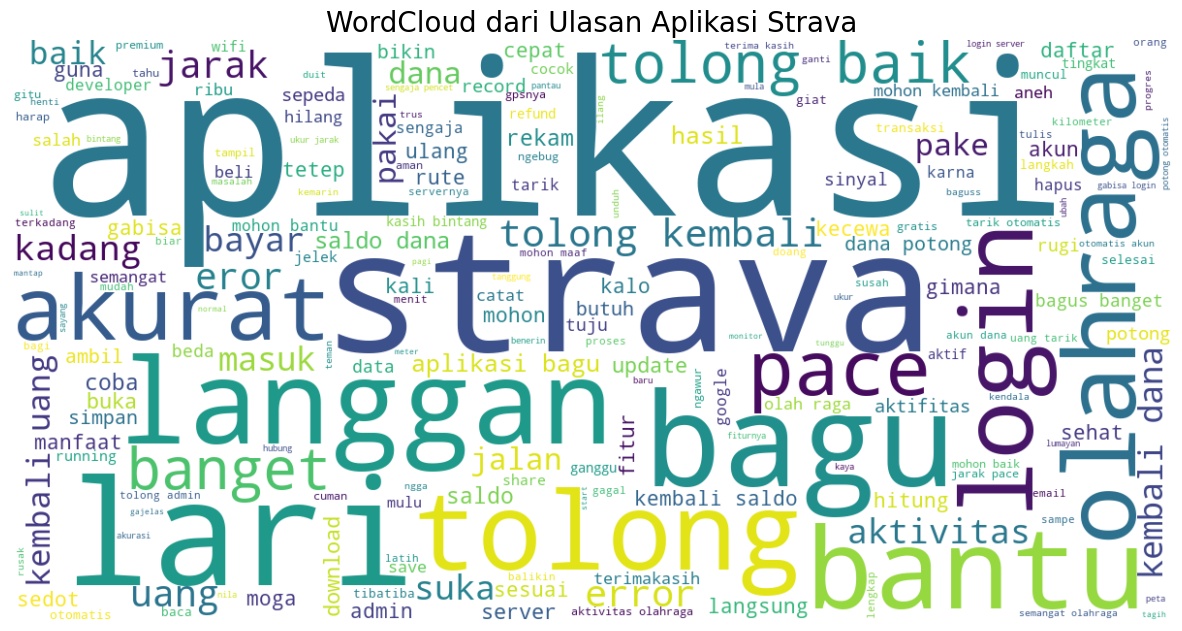

In [20]:
# Gabungkan semua teks bersih menjadi satu string
all_text = ' '.join(dff['preprocessed_text'])

if all_text:
    # Membuat objek WordCloud
    wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(all_text)

    # Menampilkan WordCloud
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('WordCloud dari Ulasan Aplikasi Strava', fontsize=20)
    plt.show()
else:
    print("⚠️ Tidak ada kata yang tersisa untuk membuat WordCloud setelah diproses.")


# Menyimpan Hasil

In [25]:
try:
    # 1. Tentukan kolom yang ingin disimpan
    kolom_untuk_disimpan = ['review', 'preprocessed_text', 'score']
    
    # 2. Tentukan nama file output
    nama_file_output = "Review_Strava_Processed_Final.csv"
    
    # 3. Pilih kolom tersebut dan langsung simpan ke file CSV
    dff[kolom_untuk_disimpan].to_csv(nama_file_output, index=False, encoding='utf-8')
    
    print(f"✅ File berhasil disimpan sebagai: '{nama_file_output}'")
    print("Kolom yang disimpan: review, preprocessed_text, score")

except KeyError:
    print("❌ Error: Salah satu dari kolom 'review', 'preprocessed_text', atau 'score' tidak ditemukan.")
except NameError:
    print("❌ Error: DataFrame 'dff' tidak ditemukan. Jalankan sel sebelumnya.")

✅ File berhasil disimpan sebagai: 'Review_Strava_Processed_Final.csv'
Kolom yang disimpan: review, preprocessed_text, score
